In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
leaderboard = {}

# Load the data
Load matrix and create list of samples and entries

In [3]:
df = pandas.read_csv("results/reannotated_allfusions_binmx_v2.tsv", sep="\t", index_col=0)
df.columns = df.columns.map(lambda x:x.replace(".", "|"))
samples = list(set(i.split("|")[0] for i in df.columns if i not in ['fusion_key', 'fusion_id']))
entries = list(set(i.split("|")[1] for i in df.columns if i not in ['fusion_key', 'fusion_id']))
entries.remove("truth")

In [4]:
def getConfMatrix(df, entries, sample, truth):
    o = {}
    for e in entries:
        k = "%s|%s" % (sample, e)
        if k in df:
            pos = df[df[k] > 0].index
            tp = sum(pos.isin(truth))
            fp = sum(~pos.isin(truth))
            fn = sum(~truth.isin(pos))
            o[e] = {'tp' : tp, 'fp' : fp, 'fn' : fn}
    return o

In [5]:
def f1Score(m):
    return (2.0 * (m['tp'])) / (2.0*m['tp'] + m['fp'] + m['fn'])

In [6]:
def tprScore(m):
    return (m['tp']) / (m['tp'] + m['fn'])

In [7]:
def fdrScore(m):
    return (m['fp']) / (m['fp'] + m['tp'])

# Create overall senstivity scores

In [8]:
tpr_data = {}
fdr_data = {}
f1_data = {}
count_data = {}
tp_data = {}
call_data = {}
for s in samples:
    td = {}
    fd = {}
    tName = "%s|truth" % (s)
    if tName in df.columns:
        t = df[ df[tName] == 1 ].index
    else: 
        t = pandas.Series([])
    res = getConfMatrix(df, entries, s, t)
    tpr_data[s] = dict( (a[0], tprScore(a[1])) for a in res.items() )
    fdr_data[s] = dict( (a[0], fdrScore(a[1])) for a in res.items() )
    f1_data[s] = dict( (a[0], f1Score(a[1])) for a in res.items() )
    tp_data[s] = dict( (a[0], a[1]['tp']) for a in res.items() )
    call_data[s] = dict( (a[0], a[1]['tp'] + a[1]['fp']) for a in res.items() )
    count_data[s] = len(t)
tpr_df = pandas.DataFrame(tpr_data)
fdr_df = pandas.DataFrame(fdr_data)
f1_df = pandas.DataFrame(f1_data)
tp_df = pandas.DataFrame(tp_data)
call_df = pandas.DataFrame(call_data)
spike_count = pandas.Series(count_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


In [9]:
leaderboard['spike_tpr'] = tpr_df.sum(axis=1) / len(samples)

In [10]:
leaderboard['spike_fdr'] = fdr_df.sum(axis=1) / len(samples)

In [11]:
leaderboard['spike_f1'] = f1_df.sum(axis=1) / len(samples)

In [12]:
leaderboard['spike_call_count'] = call_df.sum(axis=1)

In [13]:
leaderboard['spike_tp_count'] = tp_df.sum(axis=1)

In [14]:
def entryColumns(a, df):
    c = []
    for b in samples:
        k = "%s|%s" % (b, a)
        if k in df.columns:
            c.append(k)
    return c

# Build correlation matrix between all entries

In [15]:
data = {}
for i in entries:
    for j in entries:
        a = df[entryColumns(i, df)].sum(axis=1)
        b = df[entryColumns(j, df)].sum(axis=1)
        c = a.corr(b)
        data[i] = {**data.get(i, {}), **{j:c}}
        data[j] = {**data.get(j, {}), **{i:c}}
corrDF = pandas.DataFrame(data)

In [16]:
workingEntries = corrDF.columns[ corrDF.apply(lambda x:x.isnull().sum(), axis=0) != corrDF.shape[0] ]

In [17]:
def thresholdGroup(distDF, threshold):
    groupMap = pandas.Series(dict((a[1], a[0]) for a in enumerate(distDF.columns)))
    while True:
        change = False
        for i in groupMap.index:
            t = distDF.columns[distDF[i] > threshold]
            for j in t:
                if j != i and groupMap[i] != groupMap[j]:
                    n = groupMap.copy()
                    n[n==groupMap[j]] = groupMap[i]
                    if not n.equals(groupMap):
                        change = True
                    groupMap = n
        if not change:
            break
    d = {}
    for i, j in groupMap.items():
        d[j] = d.get(j, []) + [i]
    return list(d.values())

In [18]:
clines = {}
for i in samples:
    if i != 'giab':
        t = i.split("_")
        cell = t[0]
        if len(t[1]) == 1 or t[1][1] == "A": # skip the technical replicates except for the one marked A
            if cell in clines:
                clines[cell].append(i)
            else:
                clines[cell] = [i]

In [19]:
true_sites = set()
for c in df.columns:
    if c.endswith("|truth"):
        true_sites.update(set(df[df[c] > 0][c].index))

In [29]:
def new_truth(df, sample, new_truth):
    k = "%s|truth" % (sample)
    if k in df.columns:
        orig_truth = (df[k][ df[k] == 1 ]).index
    else:
        orig_truth = pandas.Index([])
    return orig_truth.append(new_truth).unique()

In [21]:
data = {}
for s in samples:
    tName = "%s|truth" % (s)
    if tName in df.columns:
        t = df[df[tName] == 1].index
    else:
        t = pandas.Series([])
    truthTP = pandas.Series(dict((a, b['tp']) for a,b in getConfMatrix(df, entries, s, t).items()))
    data[s] = (truthTP / spike_count[s])[entries]
truthRecall = pandas.DataFrame(data)

/mnt/home/ellrott/.local/lib/python3.6/site-packages/pandas/core/series.py:951: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


# Build set of less-then-correlated methods, with recall rate of 0.6 or better

In [22]:
entryGroups = thresholdGroup(corrDF.reindex(columns=workingEntries, index=workingEntries), 0.9)
repSet = []
for i in entryGroups:
    scores = truthRecall.loc[i].mean(axis=1).sort_values(ascending=False)
    if scores[0] > 0.6:
        repSet.append(scores.index[0])

# For the representative set, what is the expected recall across all samples and all methods

In [23]:
truthRecall.loc[repSet].mean().mean()

0.8771707459207458

In [24]:
cellCombined = {}
cellSampleCount = {}
for c, e in clines.items():
    cols = list(b for b in ("%s|%s" % (a[0], a[1]) for a in itertools.product(e, repSet)) if b in df.columns)
    csum = df[cols].sum(axis=1)
    csum = csum[csum > 1][csum.index.difference(true_sites)].dropna()
    cellCombined[c] = csum
    cellSampleCount[c] = len(cols)

In [25]:
clines.values()

dict_values([['HCC1143_5A1', 'HCC1143_3', 'HCC1143_1', 'HCC1143_4', 'HCC1143_2'], ['PC9_1', 'PC9_5', 'PC9_2', 'PC9_3', 'PC9_4'], ['LNCapFGC_1', 'LNCapFGC_5', 'LNCapFGC_2', 'LNCapFGC_3', 'LNCapFGC_4'], ['PC3_4', 'PC3_3', 'PC3_2', 'PC3_1', 'PC3_5'], ['A549_5', 'A549_3', 'A549_1', 'A549_2', 'A549_4'], ['JurkatI92_4', 'JurkatI92_2', 'JurkatI92_1', 'JurkatI92_5', 'JurkatI92_3']])

## For a sample cell line, show number of histogram of consensus calls

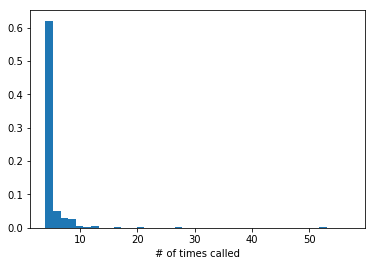

In [26]:
cellCombined['LNCapFGC'][ cellCombined['LNCapFGC'] > 3 ].hist(density=True, grid=False, bins=40)
_=plt.xlabel('# of times called')

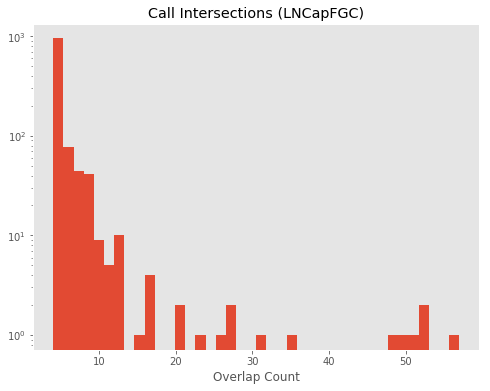

In [27]:
figSize=(8,6)
plt.figure(figsize=figSize)
plt.style.use('ggplot')
plt.title("Call Intersections (LNCapFGC)")
cellCombined['LNCapFGC'][ cellCombined['LNCapFGC'] > 3 ].hist(grid=False, bins=40, log=True)
_=plt.xlabel('Overlap Count')

## Example TPR projection using pseudo-truths for a single cell line

In [30]:
c = "LNCapFGC"
summary = {}
for l in clines[c]:
    o = {}
    for t in sorted(cellCombined[c].value_counts().index):
        new_sites = cellCombined[c][ cellCombined[c] >= t ].index
        nt = new_truth(df, l, new_sites)
        res = getConfMatrix(df, repSet, l, nt)
        o[t] = res
    summary[l] = o

## Evaluate one of the samples using the new iTruths

In [31]:
l = "LNCapFGC_1"
o = {}
for thres, data in summary[l].items():
    o[thres] = dict( (a[0], a[1]['tp'] / (a[1]['tp'] + a[1]['fn'])) for a in data.items() )
curveDF = pandas.DataFrame(o)

In [32]:
curveDF.loc[repSet]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,...,23.0,26.0,27.0,31.0,35.0,49.0,50.0,51.0,53.0,57.0
9610272,0.008830,0.019771,0.038168,0.061594,0.141593,0.209459,0.298077,0.371795,0.444444,0.518519,...,0.84375,0.838710,0.833333,0.892857,0.888889,0.884615,0.88,0.875000,0.869565,0.857143
9609498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9609508,0.009003,0.019771,0.035623,0.074275,0.168142,0.250000,0.355769,0.448718,0.555556,0.629630,...,0.93750,0.935484,0.933333,0.928571,0.925926,0.961538,0.96,0.958333,0.956522,0.952381
7997358,0.070118,0.119810,0.113656,0.105072,0.216814,0.304054,0.403846,0.474359,0.539683,0.629630,...,0.87500,0.870968,0.866667,0.857143,0.851852,0.884615,0.88,0.875000,0.869565,0.857143
9614358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7185743,0.008310,0.018584,0.039864,0.083333,0.194690,0.283784,0.375000,0.474359,0.555556,0.629630,...,0.90625,0.903226,0.900000,0.892857,0.888889,0.884615,0.88,0.875000,0.869565,0.857143
8396553,0.005194,0.011862,0.025445,0.054348,0.132743,0.202703,0.288462,0.358974,0.444444,0.518519,...,0.81250,0.838710,0.833333,0.892857,0.888889,0.923077,0.92,0.916667,0.913043,0.904762
8517255,0.006925,0.015817,0.031383,0.067029,0.150442,0.222973,0.317308,0.410256,0.492063,0.574074,...,0.81250,0.838710,0.866667,0.857143,0.888889,0.884615,0.88,0.875000,0.869565,0.857143
8399080,0.051593,0.085409,0.084818,0.081522,0.172566,0.243243,0.326923,0.384615,0.460317,0.537037,...,0.84375,0.838710,0.833333,0.892857,0.888889,0.884615,0.88,0.875000,0.869565,0.857143
9609499,0.090028,0.136813,0.162850,0.237319,0.482301,0.574324,0.586538,0.628205,0.698413,0.703704,...,0.81250,0.806452,0.833333,0.821429,0.814815,0.807692,0.80,0.791667,0.782609,0.761905


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


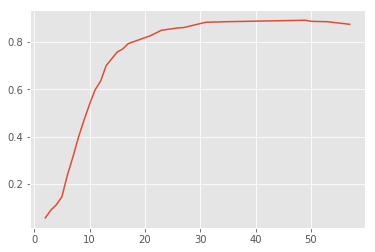

In [33]:
plt.plot(curveDF.loc[repSet].mean())

# Calculate TPR rate against iTruth (as determined by number of overlap sites) for all cell lines now

In [34]:
summary = {}
for c in clines:
    for l in clines[c]:
        o = {}
        for t in sorted(cellCombined[c].value_counts().index):
            new_sites = cellCombined[c][ cellCombined[c] >= t ].index
            nt = new_truth(df, l, new_sites)
            res = getConfMatrix(df, repSet, l, nt)
            o[t / cellSampleCount[c]] = pandas.Series( dict( (a[0], tprScore(a[1])) for a in res.items()) ).mean()
        summary[l] = o
        

In [35]:
sum(list( (cellCombined[c] >= 10).sum() for c in cellCombined)) 

306

Text(0, 0.5, 'TPR given psuedo truth')

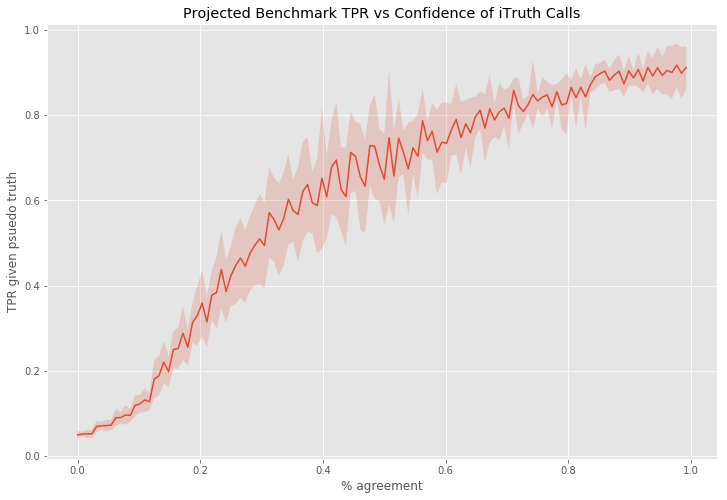

In [36]:
sumdf = pandas.DataFrame(summary)
x = np.arange(sumdf.shape[0]) / sumdf.shape[0]
ymean = sumdf.mean(axis=1)
yerr = sumdf.std(axis=1)

figSize=(12,8)
plt.figure(figsize=figSize)
plt.style.use('ggplot')
plt.plot(x, ymean)
plt.fill_between(x, ymean - yerr, ymean + yerr,
                alpha=0.2, )
plt.title("Projected Benchmark TPR vs Confidence of iTruth Calls")
plt.xlabel("% agreement")
plt.ylabel("TPR given psuedo truth")
#sumdf.mean(axis=1).plot(yerr=sumdf.std(axis=1))

In [37]:
print(sumdf.mean(axis=1).to_dict())

{0.03278688524590164: 0.05011162183822811, 0.03333333333333333: 0.05210214449942603, 0.03389830508474576: 0.052570361252175055, 0.03508771929824561: 0.05256377410103382, 0.04918032786885246: 0.0701673561732655, 0.05: 0.07110287398668794, 0.05084745762711865: 0.07196329750241326, 0.05263157894736842: 0.07270101848401275, 0.06557377049180328: 0.09046050458215453, 0.06666666666666667: 0.09049056897931909, 0.06779661016949153: 0.09651336965837866, 0.07017543859649122: 0.09588038498188865, 0.08196721311475409: 0.11902443077534723, 0.08333333333333333: 0.12272170768214079, 0.0847457627118644: 0.13198136190658213, 0.08771929824561403: 0.12774836512241547, 0.09836065573770492: 0.1809260999071941, 0.1: 0.18881840302584224, 0.1016949152542373: 0.22094581847304529, 0.10526315789473684: 0.19834543367942153, 0.11475409836065574: 0.25002631776825324, 0.11666666666666667: 0.2528859139041013, 0.11864406779661017: 0.2888636363636364, 0.12280701754385964: 0.25563369639912403, 0.13114754098360656: 0.3135

# Do the same psuedo calculation for the known truth set, and plot TPR

In [40]:
data = {}
for l in samples:
    tName = "%s|truth" % (l)
    if tName in df.columns:
        ts = df.loc[df[tName] == 1]
    else:
        ts = pandas.Series([])
    osum = df[ df.columns.intersection( list("%s|%s" % (l, e) for e in repSet )) ].loc[df["%s|truth" % l] == 1].sum(axis=1)
    o = {}
    for t in sorted(osum.value_counts().index):
        if t > 1:
            nt = osum[ osum >= t ].index
            res = getConfMatrix(df, repSet, l, nt)
            o[t / len(repSet)] = dict( (a[0], a[1]['tp'] / (a[1]['tp'] + a[1]['fn'])) for a in res.items() )
    data[l] = pandas.DataFrame(o).mean()

ValueError: Cannot index with multidimensional key

In [ ]:
d = pandas.DataFrame(data).transpose()

ymean = d.mean()
yerr = d.std()

plt.plot(d.columns, ymean)
plt.fill_between(d.columns, ymean - yerr, ymean + yerr,
                alpha=0.2 )

# Create new 'iTruth' based on meta-calling and recalculate statistics

In [41]:
psuedoThresh = 0.5
pf1_data = {}
ptpr_data = {}
pfdr_data = {}
ptp_data = {}
for c in clines:
    t = cellSampleCount[c] * psuedoThresh
    new_sites = cellCombined[c][ cellCombined[c] >= t ].index
    print("%s pseudo truth sites: %d" % (c, len(new_sites)))
    print("\t" + "\n\t".join(new_sites))
    for l in clines[c]:
        nt = new_truth(df, l, new_sites)
        res = getConfMatrix(df, entries, l, nt)
        pf1_data[l] = pandas.Series( dict( (a[0], f1Score(a[1])) for a in res.items()) )
        ptpr_data[l] = pandas.Series( dict( (a[0], tprScore(a[1])) for a in res.items()) )
        pfdr_data[l] = pandas.Series( dict( (a[0], fdrScore(a[1])) for a in res.items()) )
        ptp_data[l] =  pandas.Series( dict( (a[0], a[1]['tp']) for a in res.items()) )
        

HCC1143 pseudo truth sites: 13
	chr14_105886389_105886410_+_chr14_105172361_105172382_+
	chr15_72300156_72300177_-_chr15_72648947_72648968_-
	chr15_72300156_72300177_-_chr15_72654796_72654817_-
	chr17_65103274_65103295_-_chr7_43519198_43519219_+
	chr18_20889633_20889654_-_chr20_30132739_30132760_+
	chr1_8395639_8395660_+_chr1_8181523_8181544_+
	chr1_8763103_8763124_-_chr1_8934965_8934986_-
	chr3_10123137_10123158_+_chr3_9718990_9719011_+
	chr4_142610177_142610198_+_chr4_123536981_123537002_-
	chr6_158735289_158735310_+_chr18_45712355_45712376_-
	chr7_133059745_133059766_+_chr7_133848138_133848159_+
	chr7_140624355_140624376_-_chr7_140912380_140912401_+
	chrX_106084103_106084124_+_chr8_52823969_52823990_+
PC9 pseudo truth sites: 6
	chr11_62559140_62559161_-_chr11_62620576_62620597_-
	chr19_56614497_56614518_-_chr19_58123860_58123881_+
	chr19_58838469_58838490_+_chr19_59065592_59065613_-
	chr2_9576479_9576500_+_chr2_9533600_9533621_+
	chr4_142610177_142610198_+_chr4_123536981_123537002_-

In [42]:
for c in clines:
    t = cellSampleCount[c] * psuedoThresh
    new_sites = cellCombined[c][ cellCombined[c] >= t ].index
    print("%s out of %s" % (c, cellSampleCount[c]))
    print(cellCombined[c][ cellCombined[c] >= t ])

HCC1143 out of 59
chr14_105886389_105886410_+_chr14_105172361_105172382_+    55.0
chr15_72300156_72300177_-_chr15_72648947_72648968_-        30.0
chr15_72300156_72300177_-_chr15_72654796_72654817_-        39.0
chr17_65103274_65103295_-_chr7_43519198_43519219_+         44.0
chr18_20889633_20889654_-_chr20_30132739_30132760_+        57.0
chr1_8395639_8395660_+_chr1_8181523_8181544_+              44.0
chr1_8763103_8763124_-_chr1_8934965_8934986_-              43.0
chr3_10123137_10123158_+_chr3_9718990_9719011_+            53.0
chr4_142610177_142610198_+_chr4_123536981_123537002_-      40.0
chr6_158735289_158735310_+_chr18_45712355_45712376_-       51.0
chr7_133059745_133059766_+_chr7_133848138_133848159_+      30.0
chr7_140624355_140624376_-_chr7_140912380_140912401_+      38.0
chrX_106084103_106084124_+_chr8_52823969_52823990_+        40.0
dtype: float64
PC9 out of 61
chr11_62559140_62559161_-_chr11_62620576_62620597_-      34.0
chr19_56614497_56614518_-_chr19_58123860_58123881_+      39

In [43]:
leaderboard["psuedo_f1"] = pandas.DataFrame(pf1_data).mean(axis=1)
leaderboard["psuedo_tpr"] = pandas.DataFrame(ptpr_data).mean(axis=1)
leaderboard["psuedo_fdr"] = pandas.DataFrame(pfdr_data).mean(axis=1)
leaderboard["psuedo_tp_count"] = pandas.DataFrame(ptp_data).sum(axis=1)

In [44]:
pandas.DataFrame(leaderboard).rank()

,spike_tpr,spike_fdr,spike_f1,spike_call_count,spike_tp_count,psuedo_f1,psuedo_tpr,psuedo_fdr,psuedo_tp_count
7185743,28.5,9.0,28.0,16.0,28.5,28.0,31.5,8.0,31.5
7269246,3.5,31.5,3.5,25.0,3.5,2.5,2.5,32.5,2.5
7378934,31.5,23.0,16.0,23.0,31.5,20.0,29.0,16.0,30.0
7488045,7.0,28.0,7.0,27.0,7.0,5.0,7.0,30.0,7.0
7997358,17.0,25.0,13.0,30.0,17.0,13.0,20.0,22.0,19.0
8024234,11.0,18.0,17.0,13.0,11.0,15.0,9.0,18.0,9.0
8040408,14.0,21.0,10.0,32.0,14.0,10.0,26.0,27.0,15.0
8049087,19.0,13.0,22.0,19.5,19.0,22.0,22.0,11.0,23.0
8050015,3.5,31.5,3.5,9.5,3.5,2.5,2.5,32.5,2.5
8071387,12.0,17.0,18.0,15.0,12.5,16.0,11.0,19.0,10.5


In [45]:
leadDF = pandas.DataFrame(leaderboard) 

In [46]:
c = ["tpr", "f1", "fdr"]
ave_data = {}
for a in c:    
    ave_data[ "ave_%s" % a ] = pandas.DataFrame( [ leadDF[ "spike_%s" % a ], leadDF[ "psuedo_%s" % a] ] ).mean()
aveDF = pandas.DataFrame(ave_data)

In [47]:
decending = ["spike_tpr", "spike_f1", "psuedo_tpr", "psuedo_f1"]
acending = ["spike_fdr", "psuedo_fdr"]
leadRankDF = leadDF[decending].join(1.0 - leadDF[acending]).rank(ascending=False).rename(columns=lambda x: x+"_rank")

In [48]:
leaderboard = leadDF.join(leadRankDF).join(aveDF).rename(columns=lambda x:"exon_" + x)

In [49]:
leaderboard.to_csv("fusion_leaderboard_v2.tsv", sep="\t")

In [50]:
sampEnt = list(set(i for i in df.columns if i not in ['fusion_key', 'fusion_id']))
df[ df[ df.columns.to_series().filter(regex=r'truth$') ].sum(axis=1) > 0 ][sampEnt].sum(axis=1)

chr11_5275511_5275532_-_chr19_36034231_36034252_+        618
chr11_5275511_5275532_-_chr19_36034231_36034258_+        618
chr12_14840874_14840895_-_chr1_229567921_229567942_-     593
chr14_90867735_90867756_+_chr1_151374006_151374027_+     756
chr15_45003800_45003821_+_chr5_132010140_132010161_+     798
chr15_75017771_75017792_-_chr11_116707108_116707137_-    734
chr15_75017771_75017792_-_chr11_116707114_116707137_-    732
chr17_56316089_56316110_+_chr2_25384610_25384631_-       660
chr17_65362517_65362538_-_chr22_50928166_50928187_+      627
chr19_47735761_47735782_-_chr2_29072705_29072726_+       734
chr1_11907159_11907180_-_chr4_70822062_70822083_-        733
chr1_202888872_202888893_-_chr1_153946337_153946358_+    676
chr21_27542871_27542892_-_chr8_82195590_82195611_+       548
chr2_155555978_155555999_+_chr20_3596464_3596485_+       366
chr3_150780779_150780800_+_chr17_61995273_61995294_-     519
chr3_193311187_193311208_+_chr20_3063813_3063834_-       661
chr4_142610184_142610205

In [51]:
sampEnt = list(set(i for i in df.columns if i not in ['fusion_key', 'fusion_id']))

In [52]:
df[ df[ df.columns.to_series().filter(regex=r'truth$') ].sum(axis=1) > 0 ]

,A549_1|7185743,A549_1|7269246,A549_1|7378934,A549_1|7488045,A549_1|7997358,A549_1|8024234,A549_1|8040408,A549_1|8049087,A549_1|8050015,A549_1|8071387,...,PC3_1|truth,PC3_2|truth,PC3_3|truth,PC3_4|truth,PC9_2|truth,PC9_3|truth,PC9_4|truth,PC9_5|truth,fusion_key,fusion_id
chr11_5275511_5275532_-_chr19_36034231_36034252_+,1,0,1,0,1,0,1,1,0,0,...,1,1,1,1,1,1,1,1,HBG2>>GAPDHS,ENSG00000196565>>ENSG00000105679
chr11_5275511_5275532_-_chr19_36034231_36034258_+,1,0,1,0,1,0,1,1,0,0,...,1,1,1,1,1,1,1,1,HBG2>>GAPDHS,ENSG00000196565>>ENSG00000105679
chr12_14840874_14840895_-_chr1_229567921_229567942_-,1,0,1,0,1,0,0,1,0,0,...,1,1,1,1,1,1,1,1,GUCY2C>>ACTA1,ENSG00000070019>>ENSG00000143632
chr14_90867735_90867756_+_chr1_151374006_151374027_+,1,0,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,CALM1>>PSMB4,ENSG00000198668>>ENSG00000159377
chr15_45003800_45003821_+_chr5_132010140_132010161_+,1,0,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,B2M>>IL4,ENSG00000166710>>ENSG00000113520
chr15_75017771_75017792_-_chr11_116707108_116707137_-,1,0,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,CYP1A1>>APOA1,ENSG00000140465>>ENSG00000118137
chr15_75017771_75017792_-_chr11_116707114_116707137_-,1,0,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,CYP1A1>>APOA1,ENSG00000140465>>ENSG00000118137
chr17_56316089_56316110_+_chr2_25384610_25384631_-,1,0,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,LPO>>POMC,ENSG00000167419>>ENSG00000115138
chr17_65362517_65362538_-_chr22_50928166_50928187_+,1,0,1,0,1,0,1,1,0,0,...,1,1,1,1,1,1,1,1,PSMD12>>MIOX,ENSG00000197170>>ENSG00000100253
chr19_47735761_47735782_-_chr2_29072705_29072726_+,1,0,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,BBC3>>SPDYA,ENSG00000105327>>ENSG00000163806


In [58]:
leaderboard.sort_values(by='exon_ave_f1', ascending=False)

,exon_spike_tpr,exon_spike_fdr,exon_spike_f1,exon_spike_call_count,exon_spike_tp_count,exon_psuedo_f1,exon_psuedo_tpr,exon_psuedo_fdr,exon_psuedo_tp_count,exon_spike_tpr_rank,exon_spike_f1_rank,exon_psuedo_tpr_rank,exon_psuedo_f1_rank,exon_spike_fdr_rank,exon_psuedo_fdr_rank,exon_ave_tpr,exon_ave_f1,exon_ave_fdr
9609502,0.715625,0.387521,0.656470,674.0,458.0,0.770777,0.721048,0.161733,548.0,8.0,1.0,22.0,3.0,1.0,1.0,0.718336,0.713624,0.274627
8645203,0.707812,0.389539,0.651726,670.0,453.0,0.767211,0.715972,0.162897,544.0,12.5,2.0,23.0,4.0,2.0,2.0,0.711892,0.709468,0.276218
8645625,0.707812,0.430282,0.624125,748.0,453.0,0.784381,0.763002,0.182281,584.0,12.5,4.0,16.0,1.0,3.0,3.0,0.735407,0.704253,0.306281
8645601,0.710938,0.432074,0.624575,749.0,455.0,0.779630,0.758868,0.188141,581.0,9.0,3.0,17.0,2.0,4.0,4.0,0.734903,0.702103,0.310108
8396553,0.745313,0.518933,0.578648,925.0,477.0,0.738165,0.805234,0.309090,613.0,5.0,5.0,12.0,5.0,5.0,5.0,0.775273,0.658406,0.414011
8281648,0.706250,0.595741,0.509101,1057.0,452.0,0.709582,0.842542,0.373788,644.0,15.0,6.0,10.0,6.0,6.0,6.0,0.774396,0.609342,0.484764
7185743,0.718750,0.669588,0.448635,1339.0,460.0,0.635058,0.875489,0.486072,664.0,6.5,7.0,3.5,7.0,9.0,8.0,0.797119,0.541846,0.577830
9610021,0.718750,0.672556,0.445864,1352.0,460.0,0.631311,0.875489,0.490732,664.0,6.5,8.0,3.5,8.0,10.0,9.0,0.797119,0.538587,0.581644
8517255,0.629687,0.608841,0.430269,1053.0,403.0,0.607032,0.756626,0.474056,544.0,19.0,10.0,18.0,9.0,7.0,7.0,0.693157,0.518650,0.541449
9609508,0.756250,0.685785,0.433112,1623.0,484.0,0.553374,0.818698,0.569094,624.0,2.0,9.0,11.0,10.0,11.0,10.0,0.787474,0.493243,0.627439
